In [1]:
from chromatic_fitting import *

Running chromatic_fitting v0.11.1!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


In [2]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pymc3 as pm
# import pymc3_ext as pmx
import exoplanet as xo
import os
import starry
from corner import corner

np.random.seed(12)
starry.config.lazy = True
starry.config.quiet = True

In [96]:
map = starry.Map(ydeg=5)
map.add_spot(amp=-0.075, sigma=0.1, lat=0, lon=-30)
A_y = np.array(map.y[1:])

A = dict(
    ydeg=5,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=80.0,  # inclination in degrees
    amp=1.0,  # amplitude (a value prop. to luminosity)
    r=1.0,  #  radius in R_sun
    m=1.0,  # mass in M_sun
    prot=1.25,  # rotational period in days
    u=[0.40, 0.25],  # limb darkening coefficients
    y=A_y,  # the spherical harmonic coefficients
)

In [97]:
with pm.Model() as model:

    # Primary
    pri = starry.Primary(
        starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
        r=A["r"],
        m=A["m"],
        prot=A["prot"],
    )
    pri.map[1:] = A["u"]
    
    pri.map.spot(contrast=3, radius=20, lat=0, lon=-30)

    # System
#     sys = starry.System(pri, sec)

In [98]:
pri.map.show(theta=np.linspace(0, 360, 50))

In [ ]:
t = np.linspace(-2.5, 2.5, 1000)
flux_true = eval_in_model(pri.map.flux(theta=360 * (t/A["prot"])), model=model)
sigma = 0.05
flux = flux_true + sigma * np.random.randn(len(t))
ferr = sigma * np.random.randn(len(t))

fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.3, ms=2)
# plt.errorbar(t, flux, ferr, c="k", alpha=0.3)
ax.plot(t, flux_true, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

In [101]:
with pm.Model() as mod:
    
    prot = 1.0

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    contrast = pm.Normal("contrast", mu=1.0, sigma=5.0)
    radius = pm.Normal("radius", mu=30.0, sigma=20.0)
    lat = pm.Uniform('lat', lower=-90, upper=90, testval=10)
    lon = pm.Uniform('lon', lower=-90, upper=90, testval=10)

    pri = starry.Primary(
        starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
        r=A["r"],
        m=A["m"],
        prot=A["prot"],
    )
    pri.map[1:] = A["u"]
    
    pri.map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)
    
    # Our model for the flux
#     print(eval_in_model(pri.map.flux(theta=360*t/A["prot"])))
    flux_model = pm.Deterministic("flux_model", pri.map.flux(theta=360*t/A["prot"]))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=sigma, observed=flux)

In [102]:
with mod:
    map_soln = pmx.optimize()

optimizing logp for variables: [lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -277.1109137647193 -> 1573.4516170382549


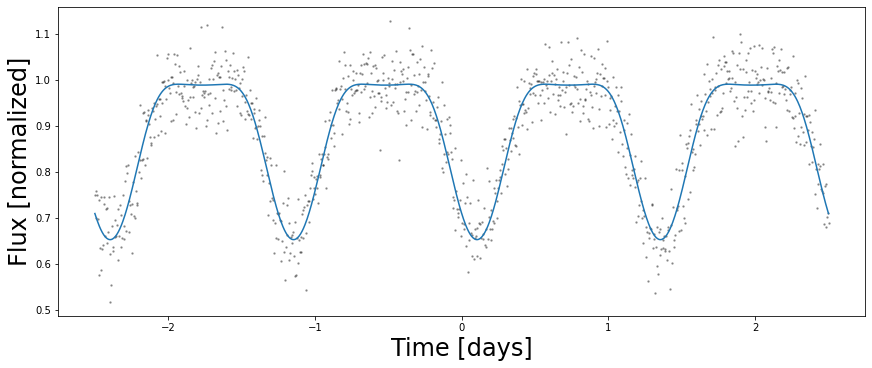

In [103]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [ ]:
with mod:
    trace = pm.sample()

/var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/ipykernel_45257/1765847016.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lon, lat, radius, contrast]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
